<a href="https://colab.research.google.com/github/Pablobm3/Detector-de-Balsas/blob/main/LinkNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Add, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

# Rutas
directorio_imagenes = "/content/drive/MyDrive/imagenes_balsas/No_Mountains/img"
directorio_mascaras = "/content/drive/MyDrive/imagenes_balsas/No_Mountains/masks/"
nombres_imagenes = [f"Balsa{i}.tiff" for i in range(1, 14)]
mascaras = [f"Mask{i}.tiff" for i in range(1, 14)]

def dividir_en_subimagenes(imagen, mascara, size=(256, 256), superposicion=50):
    """Divide una imagen y su máscara en subimágenes de tamaño dado."""
    img_width, img_height = imagen.size
    patch_width, patch_height = size
    subimagenes, submascaras = [], []

    for i in range(0, img_width, patch_width - superposicion):
        for j in range(0, img_height, patch_height - superposicion):
            if i + patch_width > img_width:
                i = img_width - patch_width
            if j + patch_height > img_height:
                j = img_height - patch_height

            subimg = imagen.crop((i, j, i + patch_width, j + patch_height))
            submask = mascara.crop((i, j, i + patch_width, j + patch_height))
            subimagenes.append(np.array(subimg) / 255.0)
            submascaras.append(np.array(submask) / 255.0)

    return subimagenes, submascaras

def cargar_datos(directorio_imagenes, directorio_mascaras, nombres_imagenes, mascaras, size=(256, 256), superposicion=50):
    """Carga imágenes y máscaras y las divide en subimágenes."""
    imagenes, etiquetas = [], []
    for nombre_imagen, nombre_mascara in zip(nombres_imagenes, mascaras):
        img = Image.open(os.path.join(directorio_imagenes, nombre_imagen))
        mask = Image.open(os.path.join(directorio_mascaras, nombre_mascara))
        subimgs, submasks = dividir_en_subimagenes(img, mask, size, superposicion)
        imagenes.extend(subimgs)
        etiquetas.extend(submasks)
    return np.array(imagenes), np.expand_dims(np.array(etiquetas), -1)

imagenes_train, etiquetas_train = cargar_datos(directorio_imagenes, directorio_mascaras, nombres_imagenes, mascaras)

train_dataset = tf.data.Dataset.from_tensor_slices((imagenes_train, etiquetas_train)).batch(4).prefetch(tf.data.AUTOTUNE)

def residual_block(x, filters):
    """Bloque residual de LinkNet."""
    res = Conv2D(filters, 3, padding="same")(x)
    res = BatchNormalization()(res)
    res = Activation("relu")(res)
    res = Conv2D(filters, 3, padding="same")(res)
    res = BatchNormalization()(res)

    x = Conv2D(filters, 1, padding="same")(x)
    x = BatchNormalization()(x)

    out = Add()([x, res])
    out = Activation("relu")(out)
    return out

def linknet(input_size=(256, 256, 3)):
    """Definición del modelo LinkNet."""
    inputs = Input(input_size)

    # Encoder
    x = residual_block(inputs, 64)
    x = MaxPooling2D()(x)
    x = residual_block(x, 128)
    x = MaxPooling2D()(x)
    x = residual_block(x, 256)
    x = MaxPooling2D()(x)
    x = residual_block(x, 512)

    # Decoder
    x = UpSampling2D()(x)
    x = residual_block(x, 256)
    x = UpSampling2D()(x)
    x = residual_block(x, 128)
    x = UpSampling2D()(x)
    x = residual_block(x, 64)

    outputs = Conv2D(1, 1, activation="sigmoid")(x)

    return Model(inputs, outputs)

modelo_linknet = linknet()

def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / (denominator + tf.keras.backend.epsilon())

modelo_linknet.compile(optimizer=Adam(learning_rate=1e-4),
                       loss=lambda y_true, y_pred: tf.keras.losses.BinaryCrossentropy()(y_true, y_pred) + dice_loss(y_true, y_pred),
                       metrics=["accuracy", tf.keras.metrics.MeanIoU(num_classes=2)])

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=5, min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=8, restore_best_weights=True, verbose=1)
]

history = modelo_linknet.fit(
    train_dataset,
    epochs=100,
    steps_per_epoch=len(imagenes_train) // 4,
    callbacks=callbacks
)

modelo_linknet.save('/content/drive/MyDrive/imagenes_balsas/modelos/NoMountain_linknet.keras')


Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 71s 227ms/step - accuracy: 0.9558 - loss: 1.0873 - mean_io_u: 0.4990 - learning_rate: 1.0000e-04
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 19s 212ms/step - accuracy: 0.9974 - loss: 0.8015 - mean_io_u: 0.4997 - learning_rate: 1.0000e-04
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 19s 210ms/step - accuracy: 0.9978 - loss: 0.7077 - mean_io_u: 0.5031 - learning_rate: 1.0000e-04
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 209ms/step - accuracy: 0.9981 - loss: 0.6312 - mean_io_u: 0.5106 - learning_rate: 1.0000e-04
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - accuracy: 0.9982 - loss: 0.5704 - mean_io_u: 0.5173 - learning_rate: 1.0000e-04
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 212ms/step - accuracy: 0.9983 - loss: 0.5166 - mean_io_u: 0.5251 - learning_rate: 1.0000e-04
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 19s 211ms/step - accuracy: 0.9985 - loss: 0.4673 - mean_io_u: 0.5322 - learning_rate: 1.0000e-04
Epoch 8/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 19s 210ms

/usr/local/lib/python3.11/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:                        loss=lambda y_true, y_pred: tf.keras.losses.BinaryCrossentropy()(y_true, y_pred) + dice_loss(y_true, y_pred),

  return {key: serialize_keras_object(value) for key, value in obj.items()}


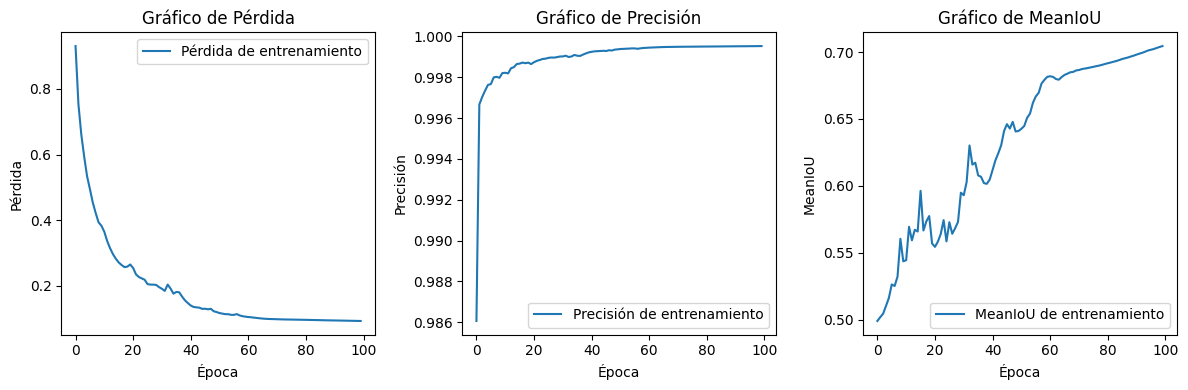

In [2]:
import matplotlib.pyplot as plt

# Gráfico de Pérdida
plt.figure(figsize=(12, 4))  # Ajustar el tamaño de la figura si es necesario
plt.subplot(1, 3, 1)  # 1 fila, 3 columnas, primer gráfico
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
# Si usaste un conjunto de validación:
# plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Gráfico de Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de Precisión
plt.subplot(1, 3, 2)  # 1 fila, 3 columnas, segundo gráfico
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
# Si usaste un conjunto de validación:
# plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Gráfico de Precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

# Gráfico de MeanIoU (si lo usaste)
plt.subplot(1, 3, 3)  # 1 fila, 3 columnas, tercer gráfico
plt.plot(history.history['mean_io_u'], label='MeanIoU de entrenamiento')
plt.title('Gráfico de MeanIoU')
plt.xlabel('Época')
plt.ylabel('MeanIoU')
plt.legend()

plt.tight_layout()  # Ajustar el espacio entre los gráficos
plt.show()

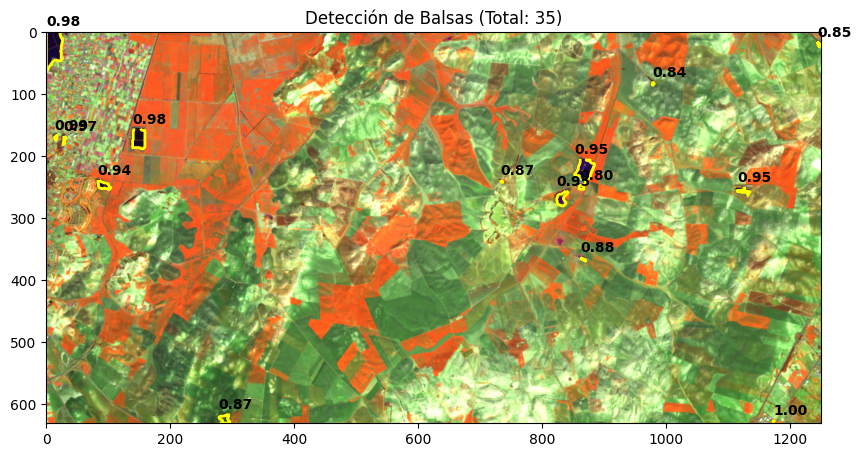

In [4]:
from tensorflow import keras
from scipy.ndimage import label
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf

# Cargar el modelo U-Net
modelo_linknet = keras.models.load_model('/content/drive/MyDrive/imagenes_balsas/modelos/NoMountain_linknet.keras', safe_mode=False)

# Función para dividir imagen en parches y hacer predicciones
def clasificar_imagen_por_parches(imagen_path, modelo, patch_size=(256, 256), superposicion=50):
    imagen = Image.open(imagen_path)
    ancho, alto = imagen.size
    prediccion_total = np.zeros((alto, ancho))
    contador = np.zeros((alto, ancho))

    for i in range(0, ancho, patch_size[0] - superposicion):
        for j in range(0, alto, patch_size[1] - superposicion):
            i = min(i, ancho - patch_size[0])  # Evitar salir del borde
            j = min(j, alto - patch_size[1])

            subimg = imagen.crop((i, j, i + patch_size[0], j + patch_size[1]))
            subimg_array = np.array(subimg) / 255.0

            prediccion = modelo.predict(np.expand_dims(subimg_array, axis=0),verbose=0)[0, :, :, 0]

            prediccion_total[j:j+patch_size[1], i:i+patch_size[0]] += prediccion
            contador[j:j+patch_size[1], i:i+patch_size[0]] += 1

    prediccion_final = np.divide(prediccion_total, contador, where=contador > 0)
    return prediccion_final

# Clasificar imagen de prueba
imagen_prueba = "/content/drive/MyDrive/imagenes_balsas/No_Mountains/img/Balsa6.tiff"
clasificacion = clasificar_imagen_por_parches(imagen_prueba, modelo_linknet)
clasificacion_binaria = (clasificacion > 0.1).astype(np.uint8)

# Etiquetado de objetos detectados
estructura = np.ones((3, 3), dtype=int)
marcado, num_balsas = label(clasificacion_binaria, structure=estructura)

# Encontrar contornos en la predicción final
contornos, _ = cv2.findContours(clasificacion_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Visualización del resultado
imagen_original = Image.open(imagen_prueba)
plt.figure(figsize=(10, 10))
plt.title(f"Detección de Balsas (Total: {num_balsas})")
plt.imshow(imagen_original)

for contorno in contornos:
    mascara = np.zeros_like(clasificacion_binaria, dtype=np.uint8)
    cv2.drawContours(mascara, [contorno], -1, 255, -1)
    probabilidad_promedio = np.mean(clasificacion[mascara == 255])

    # Obtener las dimensiones del contorno
    x, y, w, h = cv2.boundingRect(contorno)
    area = cv2.contourArea(contorno)
    aspect_ratio = max(w / h, h / w)  # Proporción de aspecto

    # Filtrar masas de agua grandes o con forma de río
    if area > 8000 or aspect_ratio > 5:
        continue  # Omitir si es demasiado grande o alargado

    if probabilidad_promedio > 0.8:
        plt.plot(contorno[:, 0, 0], contorno[:, 0, 1], color='yellow', linewidth=2)
        plt.text(x, y - 10, f"{probabilidad_promedio:.2f}", color='black', fontsize=10, fontweight='bold')

plt.show()
